In [177]:
# Notebook for computing Lyapunov Spectrum of the Lorenz 63 system
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

In [178]:
# Function to ensure QR decomposition has positive diagonals

def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

### Time Parameters

In [242]:
dt = 1.e-2 # Time step for numerical integration, this is also the interval TLE is solved over
transient = int(5.e4) # Number of transient steps
L = int(1.e5) # Steps we will sample on attractor

## Solving and Plotting Lorenz 63

In [243]:
# L63 Definition

#Parameters
a = 10.0
b = 8/3
c = 28.0
p = [a, b, c]

def L63(state, t, p):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    [a, b, c] = p
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt

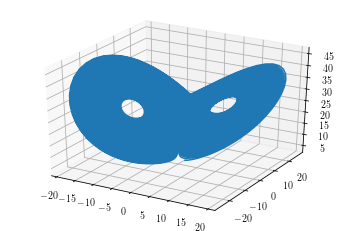

In [244]:
# Solving L63 Numerically using odeint

IC = np.array([1.0, 2.0, 3.0])
steps = transient + L # Where we're solving L63
time = np.arange(0, steps * dt, dt)
solution = odeint(L63, IC, time, (p,))

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
plt.show()

## Function for Jacobians

We will only need the jacobians after the transient period.

In [245]:
# Function to calucate Jacobian of L63 at a point on trajectory

def Jacobian(location, parameters):
    """Returns the jacobian matrix at a given point of L63.
    Param, location, array: [x, y, z] coordinates.
    Parameters, parameters, L63 parameters.
    """
    [a, b, c] = parameters
    [x, y, z] = location
    row1 = np.array([-a, a, 0])
    row2 = np.array([c - z, -1, -x])
    row3 = np.array([y, x, -b])
    J = np.array([row1, row2, row3])
    return J

# Test of Jacobian Function
# location = [2, 0, 1]
# print(Jacobian(location, [a, b, c]))

In [ ]:
# Storing time series of Jacobians
# Note that J(step * dt) = Jacobians[:, :, step]

# jacobians = np.zeros((3, 3, L)) # Time series of Jacobian matrix after transient. 
# for t in range(L): #Indexed as (row, column, transient + step)
# #     print(f'Solution to Lorenz at step {t} (time {time[t]}) is\n {solution[t]}\n\n')
# #     print(f'Jacobian at step {t} (time {time[t]}) is\n{Jacobian(solution[t], [a, b, c])}\n\n')
#     jacobians[:, :, t] = Jacobian(solution[transient + t], [a, b, c])
#     #jacobians[:, :, t] = np.array([[1, -2, 0], [0, -1, 0], [0, 2, -3]]) # Test with constant Jacobian
# #     print(f'Stored Jacobian is\n{jacobians[:, :, t]}\n\n')

## Solving the Tangent Linear Equations

At each point along trajectory of L63 we define a TLE. We solve this numerically with Q_k as the IC. The solution our numerical integration gives is P_k = Q_k R_k. Never need the propagator!

#### First we define eveything we need for the TLEs

In [ ]:
# RHS
def TLE(delta, time, p, state):
    """Defines RHS of the TLE at a given point on attractor.
    Param, delta, perturbation evolution being solved for.
    Param, time.
    Param, p, parameters of Lorenz system.
    Param, state, where we are on the attractor.
    """
    J = Jacobian(state, p)
    f = np.dot(J, delta)
    return f

# Time steps for TLE numerical integration
TLEtime = np.arange(0, dt, dt * 1.e-2) # Note tle is solved on interval [0, dt]

#### Function that solves TLE

In [ ]:
def solveTLE(state, oldQ):
    """ Solves tangent linear equation.
    Param, state, array: where we are on the attractor, used to define TLE.
    Param, oldQ, IC of TLE being solved. 
    """
    TLEsolution0 = odeint(TLE, oldQ[:, 0], TLEtime, (p, state)) # Solving the TLE for different IC
    col1 = TLEsolution0[-1]
    TLEsolution1 = odeint(TLE, oldQ[:, 1], TLEtime, (p, state))
    col2 = TLEsolution1[-1]
    TLEsolution2 = odeint(TLE, oldQ[:, 2], TLEtime, (p, state))
    col3 = TLEsolution2[-1]
    Pk = np.column_stack((col1, col2, col3))
    return Pk

## Benettin Algorithm for calculating the Lyapunov Spectrum

In [ ]:
# Initialising an orthogonal matrix
eps = 1.e-5
oldQ = eps * np.identity(3)

In [ ]:
lyap = np.zeros(3) # Running sum of FTLEs
lyapSum = np.zeros((L, 3)) # For storing time series of running sum

for i in range(L):
#     if (i % int(1.e3) == 0):
#         print(f'At step {i}.\n')
    state = solution[transient + i]
    Pk = solveTLE(state, oldQ)
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonals
    lyap = np.log(np.diag(R)) + lyap # Running sum
    lyapSum[i] = lyap # Storing time series of running sum

### Estimated Lyapunov Exponents

In [ ]:
T = L * dt # Time we have summed R diagonals over
print(f'Lyapunov exponents are {lyap/T}')

## Plots of FTLEs Running Average

In [ ]:
from matplotlib import rc
rc('text', usetex=True)

j = 1000 # Controls time that plots will start from

# First LE
plt.plot(np.arange(L)[j:], lyapSum[j:, 0]/(dt * np.arange(L)[j:]))
length= len(np.arange(L)[j:])
plt.plot(np.arange(L)[j:], 0.91 * np.ones(length))
plt.xlabel('Time')
plt.ylabel('$\lambda_1$')
plt.title('Running $\lambda_1$ Average')
plt.savefig('First-LE.png')

# Second LE
plt.figure()
plt.plot(np.arange(L)[j:], lyapSum[j:, 1]/(dt * np.arange(L)[j:]))
plt.plot(np.arange(L)[j:], 0 * np.ones(length))
plt.xlabel('Time')
plt.ylabel('$\lambda_2$')
plt.title('Running $\lambda_2$ Average')
plt.savefig('Second-LE.png')

# Third LE
plt.figure()
plt.plot(np.arange(L)[j:], lyapSum[j:, 2]/(dt * np.arange(L)[j:]))
plt.plot(np.arange(L)[j:], -14.58 * np.ones(length))
plt.xlabel('Time')
plt.ylabel('$\lambda_3$')
plt.title('Running $\lambda_3$ Average')
plt.savefig('Third-LE.png')
